In [1]:
import os
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
os.chdir('/Users/rraj/PythonFunctions/DCNet/')
os.getcwd()

'/Users/rraj/PythonFunctions/DCNet'

In [2]:
import torch
from torchvision.datasets import MNIST
from torchvision import transforms
from tqdm import tqdm

mnist_data = MNIST(
    root = 'data',
    train = True,                         
    transform = transforms.ToTensor(), 
    download = True,            
)

mnist_test_data = MNIST(
    root = 'data',
    train = False,                         
    transform = transforms.ToTensor(), 
    download = True,            
)

In [3]:
from torch import nn

class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 6, 5, padding=2),
            nn.Sigmoid(),
            nn.AvgPool2d(2, stride=2),
            nn.Conv2d(6, 16, 5),
            nn.Sigmoid(),
            nn.AvgPool2d(2, stride=2),
            nn.Flatten(),
            nn.Linear(400, 120),
            nn.Sigmoid(),
            nn.Linear(120, 84),
            nn.Sigmoid(),
            nn.Linear(84, 10)
        )
    def forward(self, x):
        return self.net(x)

In [4]:
from torch.utils.data import DataLoader, Dataset, RandomSampler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LeNet().to(device)

nepochs = 10
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loader = DataLoader(mnist_data, batch_size=64, sampler=RandomSampler(mnist_data))
loss_fn = torch.nn.CrossEntropyLoss()

In [5]:
import torch.nn.functional as F
from tqdm import tqdm

running_loss = 0
for epoch in range(nepochs):
    for i, data in tqdm(enumerate(loader), total=len(loader), desc=f"Epoch:{epoch+1}/{nepochs}"):
        inputs, targets = data
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()
        preds = model(inputs)
        loss = loss_fn(preds, targets)
        loss.backward()
        optimizer.step()
        
        running_loss = loss.item()
    print(f"{running_loss=:.3f}")



Epoch:1/10: 100%|██████████| 938/938 [00:13<00:00, 67.03it/s]


running_loss=0.374


Epoch:2/10: 100%|██████████| 938/938 [00:13<00:00, 67.24it/s]


running_loss=0.239


Epoch:3/10: 100%|██████████| 938/938 [00:14<00:00, 65.18it/s]


running_loss=0.123


Epoch:4/10: 100%|██████████| 938/938 [00:14<00:00, 65.67it/s]


running_loss=0.015


Epoch:5/10: 100%|██████████| 938/938 [00:14<00:00, 66.12it/s]


running_loss=0.119


Epoch:6/10: 100%|██████████| 938/938 [00:13<00:00, 67.07it/s]


running_loss=0.018


Epoch:7/10: 100%|██████████| 938/938 [00:13<00:00, 67.81it/s]


running_loss=0.010


Epoch:8/10: 100%|██████████| 938/938 [00:14<00:00, 64.06it/s]


running_loss=0.056


Epoch:9/10: 100%|██████████| 938/938 [00:14<00:00, 65.71it/s]


running_loss=0.015


Epoch:10/10: 100%|██████████| 938/938 [00:14<00:00, 66.44it/s]

running_loss=0.025


In [6]:
test_loader = DataLoader(mnist_test_data, shuffle=True)
correct = 0
with torch.no_grad():
    for input, target in test_loader:
        input = input.to(device)
        target = target.to(device)
        prediction = model(input)
        
        if target.item() == prediction.argmax().item():
            correct += 1

print(f"correct={correct/len(test_loader)}")

correct=0.9816


In [7]:
from typing import List

class ActivationExtractor(nn.Module):
    def __init__(self, model: nn.Module, layers: List[int]):
        super().__init__()
        self.model = model
        self.layers = layers
        self._activations = {layer: torch.empty(0) for layer in layers}
        
        for layer in layers:
            self.model.net[layer].register_forward_hook(self._get_activation(layer))
        
    def _get_activation(self, layer: int):
        def hook(_, __, output):
            self._activations[layer] = output.detach()
                
        return hook
    
    def forward(self, x: torch.Tensor):
        self.model(x)
        return self._activations

In [8]:
monitored_layers = [6, 7, 9, 11]
activations = {layer: torch.empty(0) for layer in monitored_layers}
activation = ActivationExtractor(model, layers=monitored_layers)
test_loader = DataLoader(mnist_test_data, shuffle=True)
targets = []
with torch.no_grad():
    for input, target in tqdm(test_loader, total=len(test_loader)):
        input = input.to(device)
        targets.append(target.item())
        act = activation(input)
        for layer in monitored_layers:
            activations[layer] = torch.cat((activations[layer], act[layer]), dim=0)
        


100%|██████████| 10000/10000 [00:40<00:00, 244.58it/s]


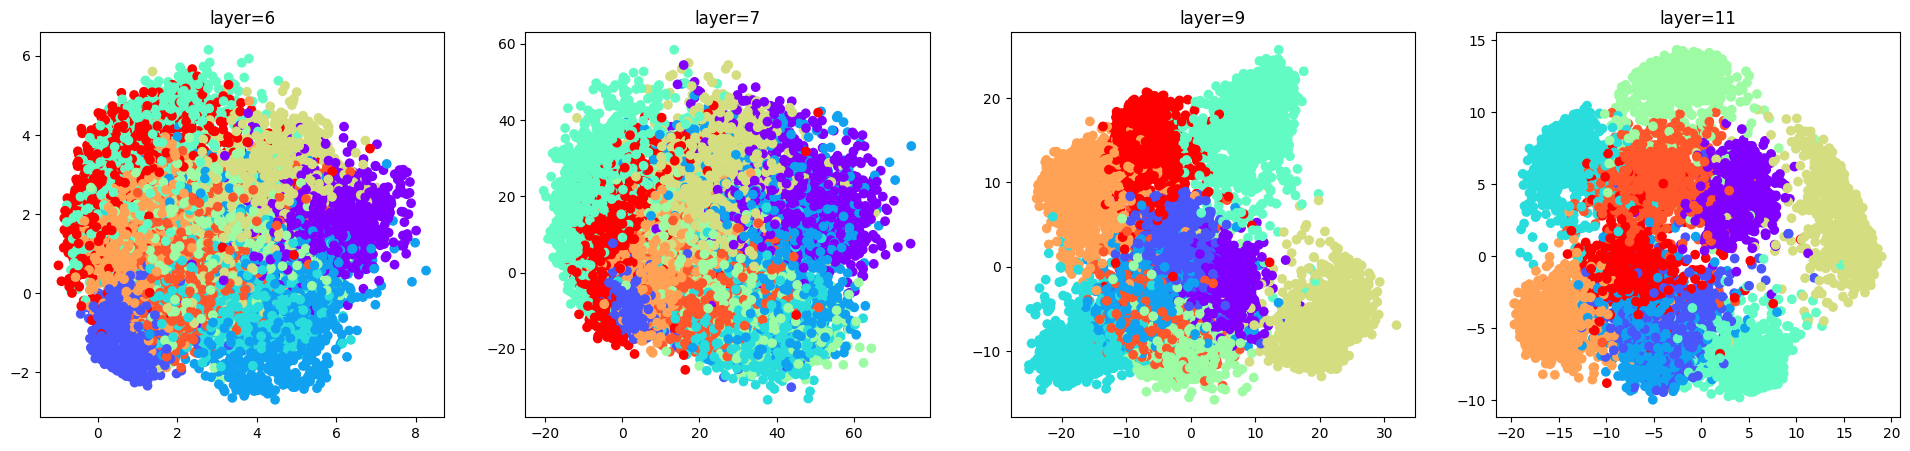

In [9]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

fig, ax = plt.subplots(1, 4, figsize=(24, 5))
for idx, layer in enumerate(monitored_layers):
    pca.fit(activations[layer].numpy())
    components = torch.tensor(pca.components_)
    projection = torch.mm(activations[layer], components.T)

    ax[idx].scatter(projection[:,0], projection[:,1], c=targets, cmap='rainbow')
    ax[idx].set_title(f"{layer=}")

In [10]:
import torch
from torch.utils.data import DataLoader, Dataset, RandomSampler
import torch.nn.functional as F
from transformations import Transform

class TripletLoader:
    def __init__(self, dataset: Dataset, transforms: Transform):
        self.dataset = dataset
        self.transforms = transforms
        
    def __call__(self, nsamples: int):
        self.nsamples = nsamples
        self._initialize_loader()
        return self
    
    def __iter__(self):
        return self
    
    def __next__(self):
        if self.current < self.nsamples:
            self.current += 1
            samples, targets = self._triplet()
            transformed_samples = [self.transforms(samples[i], label=targets[i].item()) for i in range(3)]
            return transformed_samples
        raise StopIteration
    
    def _initialize_loader(self):
        self.loader = DataLoader(self.dataset, sampler=RandomSampler(self.dataset), batch_size=100)
        self.current = 0
        
    def _triplet(self):
        anchor_idx, positive_idx, negative_idx = 0, float('inf'), float('inf')
        s, t = next(iter(self.loader))
        while torch.tensor(positive_idx).isinf() or torch.tensor(negative_idx).isinf():
            try:
                positive_idx = (t == t[0]).nonzero().flatten()[1].item()
                negative_idx = (t != t[0]).nonzero().flatten()[1].item()
            except IndexError:
                s, t = next(iter(self.loader))
        indices = [anchor_idx, positive_idx, negative_idx]
        return s[indices], t[indices]
        

In [11]:
from torch.linalg import multi_dot

def siamese_grad(weights: torch.Tensor, embeddings: torch.Tensor, alpha: float = 0.5):
    grad = torch.zeros_like(weights)
    emb_anc = embeddings[0]
    emb_pos = embeddings[1]
    emb_neg = embeddings[2]
    
    d_pos = torch.norm(emb_pos - emb_anc)
    d_neg = torch.norm(emb_neg - emb_anc)
    d_pos_neg = emb_pos - emb_neg
    if d_pos - d_neg + alpha > 0:
        grad = multi_dot((weights, emb_anc.T, d_pos_neg)) + multi_dot((weights, d_pos_neg.T, emb_anc)) - torch.mm(weights, torch.mm(emb_pos.T, emb_pos) - torch.mm(emb_neg.T, emb_neg))
    return grad

In [21]:
from torch.linalg import multi_dot
from torch.nn.functional import normalize

def siamese_grad_cosine(weights: torch.Tensor, embeddings: torch.Tensor, alpha: float = 0.2):
    grad = torch.zeros_like(weights)
    emb_anc = normalize(torch.mm(embeddings[0], weights), p=2, dim=1)
    emb_pos = normalize(torch.mm(embeddings[1], weights), p=2, dim=1)
    emb_neg = normalize(torch.mm(embeddings[2], weights), p=2, dim=1)
    
    d_pos = 1 - torch.mm(emb_anc, emb_pos.T)
    d_neg = 1 - torch.mm(emb_anc, emb_neg.T)
    if d_pos - d_neg + alpha > 0:
        grad = multi_dot((weights, emb_anc.T, emb_pos - emb_neg))
    return grad, d_pos - d_neg + alpha

In [13]:
import transformations
from transformations import Scale, Identity, ToVector

triplet_loader = TripletLoader(mnist_data, transforms=Identity())

In [23]:
layer = 7
layer_dim = 120

nepochs = 5
nbatches = 300
batch_size = 64
lr = 0.01

weights = torch.randn(layer_dim, layer_dim)

for epoch in range(nepochs):
    loss = 0
    for batches in tqdm(range(nbatches), desc=f"Epoch:{epoch+1}/{nepochs}"):
        grad = torch.zeros(120, 120)
        for triplet in triplet_loader(batch_size):
            anc = triplet[0].unsqueeze(0).to(device)
            pos = triplet[1].unsqueeze(0).to(device)
            neg = triplet[2].unsqueeze(0).to(device)
            
            emb_anc = activation(anc)[layer]
            emb_pos = activation(pos)[layer]
            emb_neg = activation(neg)[layer]
            
            g, l = siamese_grad_cosine(weights, [emb_anc, emb_pos, emb_neg])
            grad += g
            loss += l
        weights += lr*grad/batch_size
    print(f"{loss=}")

Epoch:1/5: 100%|██████████| 300/300 [04:02<00:00,  1.24it/s]


loss=tensor([[-1214.5656]])


Epoch:2/5: 100%|██████████| 300/300 [03:59<00:00,  1.25it/s]


loss=tensor([[-1364.2258]])


Epoch:3/5:  11%|█▏        | 34/300 [00:27<03:37,  1.22it/s]


KeyboardInterrupt: 

In [19]:
batch_size=5
for triplet in triplet_loader(batch_size):
    anc = triplet[0].unsqueeze(0).to(device)
    pos = triplet[1].unsqueeze(0).to(device)
    neg = triplet[2].unsqueeze(0).to(device)
    print(anc.sum(), pos.sum(), neg.sum())
            
    emb_anc = activation(anc)[11]
    emb_pos = activation(pos)[11]
    emb_neg = activation(neg)[11]
    print(emb_anc, emb_pos, emb_neg)

tensor(93.3294) tensor(144.7804) tensor(117.3922)
tensor([[-5.1271, -0.7847,  9.0924, -2.3517, -1.8122, -7.7070, -5.4292, -2.9131,
         -3.1059, -5.5962]]) tensor([[-5.3356,  1.8927,  5.1979, -0.1209, -5.0251, -4.9654, -8.4776, -0.8116,
         -3.4921, -4.2823]]) tensor([[ 7.5072, -8.2936, -0.8763, -4.3566, -6.0395, -2.3189, -1.6047, -4.4824,
         -2.3879, -1.9182]])
tensor(43.9451) tensor(107.1412) tensor(54.5333)
tensor([[-6.3486, -2.2056, -5.2068, -6.9708,  6.9780, -2.7780, -2.1776, -3.1830,
         -2.7974,  1.3126]]) tensor([[-5.2161, -3.6131, -4.4437, -9.4269,  9.6345, -3.8411, -0.6275, -2.9713,
         -3.4921,  0.7689]]) tensor([[-7.1215,  6.5531, -1.1548, -4.8862,  0.0994, -6.2667, -4.7127, -2.7720,
          0.3221, -2.4363]])
tensor(146.2353) tensor(63.1294) tensor(127.2824)
tensor([[-2.4912, -2.5587,  6.6005, -1.2128, -5.6553, -7.6729, -8.1792, -0.8296,
         -0.6979, -4.1515]]) tensor([[-3.0453, -3.9118,  1.7824, -4.5175,  1.8588, -3.0166, -2.0805, -4.5248,


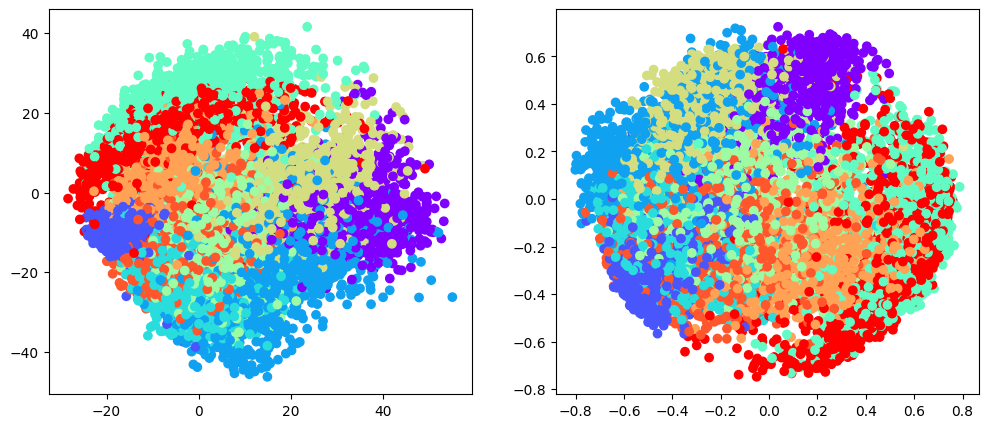

In [25]:
layer = 7
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

pca.fit(activations[layer].numpy())
components = torch.tensor(pca.components_)
projection = torch.mm(activations[layer], components.T)
ax[0].scatter(projection[:,0], projection[:,1], c=targets, cmap='rainbow')

transformed_activations = normalize(torch.mm(activations[layer], weights), p=2, dim=1)
pca.fit(transformed_activations.numpy())
components = torch.tensor(pca.components_)
projection = torch.mm(transformed_activations, components.T)
ax[1].scatter(projection[:,0], projection[:,1], c=targets, cmap='rainbow')

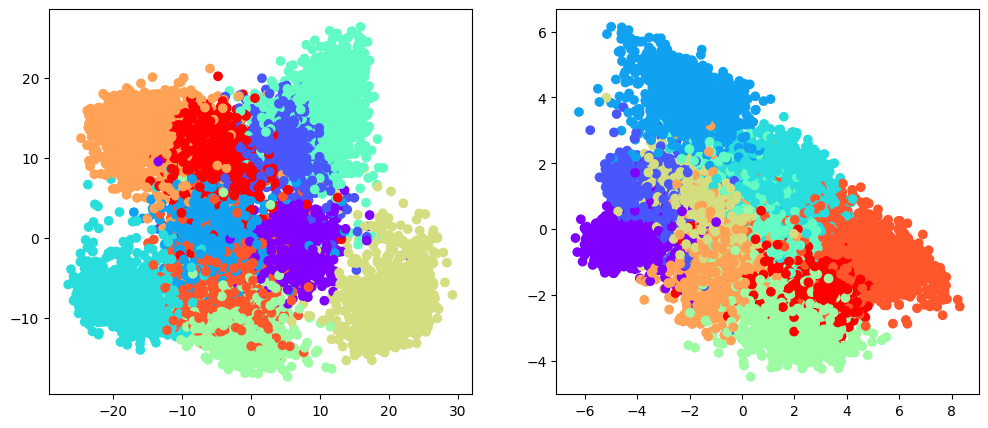

In [18]:
layer = 9
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

pca.fit(activations[layer].numpy())
components = torch.tensor(pca.components_)
projection = torch.mm(activations[layer], components.T)
ax[0].scatter(projection[:,0], projection[:,1], c=targets, cmap='rainbow')

transformed_activations = torch.mm(activations[layer], weights)
pca.fit(transformed_activations.numpy())
components = torch.tensor(pca.components_)
projection = torch.mm(activations[layer], components.T)
ax[1].scatter(projection[:,0], projection[:,1], c=targets, cmap='rainbow')

In [25]:
from layers import DiscriminationModule
from initialization import DatasetInitializer
from loading import SequentialLoader

transform = transformations.Compose([Scale(), ToVector()])
triplet_loader_dc = TripletLoader(mnist_data, transforms=transform)
loader = SequentialLoader(mnist_data, transforms=transform)

dcnet = DiscriminationModule(500, DatasetInitializer(mnist_data, transforms=transform), beta=0.98)

In [26]:
nbatches = 100
batch_size = 200
for _ in tqdm(range(nbatches)):
    for x in loader(batch_size):
        dcnet(x)
    dcnet.organize()

100%|██████████| 100/100 [1:00:27<00:00, 36.27s/it]


In [28]:
nepochs = 1
nbatches = 100
batch_size = 64
lr = 0.01

weights = torch.randn(500, 500)

for epoch in range(nepochs):
    for batches in tqdm(range(nbatches), desc=f"Epoch:{epoch+1}/{nepochs}"):
        grad = torch.zeros(500, 500)
        for triplet in triplet_loader_dc(batch_size):
            anc = triplet[0]
            pos = triplet[1]
            neg = triplet[2]
            
            emb_anc = dcnet(anc)
            emb_pos = dcnet(pos)
            emb_neg = dcnet(neg)
            
            grad += siamese_grad(weights, [emb_anc, emb_pos, emb_neg])
        weights += lr*grad/batch_size

Epoch:1/1: 100%|██████████| 100/100 [58:19<00:00, 34.99s/it]


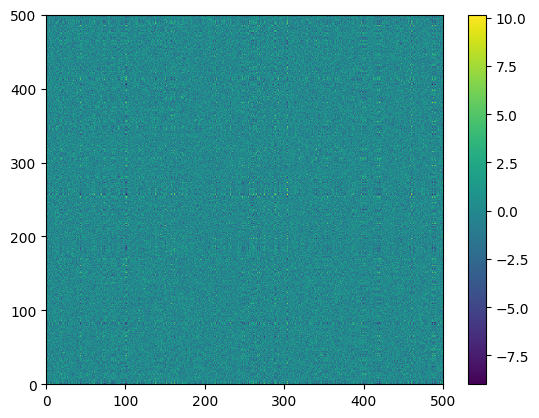

In [29]:
plt.pcolormesh(weights)
plt.colorbar()

In [30]:
test_loader = DataLoader(mnist_test_data, shuffle=True)
targets = []
activations = torch.empty(0)
transformed_activations = torch.empty(0)
for idx, data in tqdm(enumerate(test_loader), total=len(test_loader)):
        input, target = data
        targets.append(target.item())
        input = transform(input)
        output = dcnet(input)
        tranformed_output = torch.mm(output, weights)
        activations = torch.cat((activations, output), dim=0)
        transformed_activations = torch.cat((transformed_activations, tranformed_output), dim=0)
        
        if idx >= 2000:
                break        

 20%|██        | 2000/10000 [06:16<25:06,  5.31it/s]  


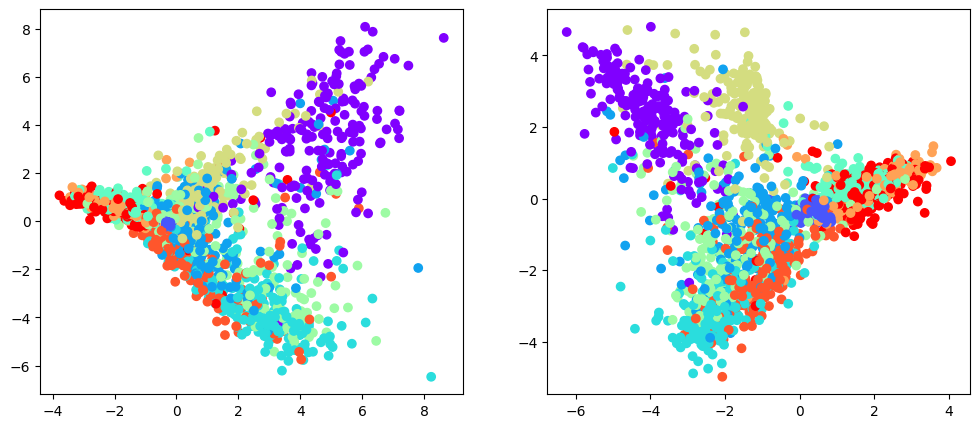

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

pca.fit(activations.numpy())
components = torch.tensor(pca.components_)
projection = torch.mm(activations, components.T)
ax[0].scatter(projection[:,0], projection[:,1], c=targets, cmap='rainbow')

pca.fit(transformed_activations.numpy())
components = torch.tensor(pca.components_)
projection = torch.mm(activations, components.T)
ax[1].scatter(projection[:,0], projection[:,1], c=targets, cmap='rainbow')

In [18]:
64*938

60032